In [1]:
import nn_class
import pandas as pd
import csv
import numpy as np
import pdb
import os
import matplotlib
from matplotlib import pyplot as plt
import pdb
import jax_cosmo as jc
import tomo_challenge as tc

2022-06-10 06:32:41.312228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/papi/6.0.0.12/lib64:/opt/cray/job/2.2.4-7.0.3.1_3.17__g36b56f4.ari/lib64:/opt/gcc/11.2.0/snos/lib64:/global/common/cori_cle7up03/software/darshan/3.3.1/lib
2022-06-10 06:32:41.312270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found classifier funbins
Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [2]:
def bin_edges(bin_method, bin_num, z_list):
    '''
    This function finds the bin egdes for a given method of binning
    
    input paramters are:
    bin_method: can be 'equal_chi', 'equal_z' or 'equal_num
    bin_num: the number of bins required
    z_list: the set of photo-z being used 
    
    returns an array of bin edges
    '''
    if bin_method == 'equal_chi': #funbins bin egdes by equal chi
        zgrid = np.linspace(0, z_list.max(), 1000)
        agrid = 1 / (1 + zgrid)
        model = jc.parameters.Planck15()
        chi_grid = jc.background.radial_comoving_distance(model, agrid)
        # Compute bin edges that are equally spaced in chi.
        chi_edges = np.linspace(0, chi_grid[-1], bin_num + 1)
        bin_edges = np.empty(bin_num + 1)
        bin_edges[0] = 0.
        bin_edges[-1] = z_list.max()
        bin_edges[1:-1] = np.interp(chi_edges[1:-1], chi_grid, zgrid)
        
    if bin_method == 'equal_z':
        bin_edges = np.linspace(0, z_list.max(), bin_num+1)
        
    if bin_method == 'equal_num':
        
        total_num = len(z_list)
        new_z_list = sorted(z_list)

        objects_per_bin = int(total_num / bin_num)

        #set bin edges
        #bin_edges = np.empty(bin_num+1)
        #bin_edges[0] = 0.
        #bin_edges[-1] = z_list.max()
        bin_edges = [0.]
        k = 1
        while k < bin_num:
            bin_edges.append(new_z_list[k*objects_per_bin])
            k+=1
        bin_edges.append(z_list.max())
        bin_edges = np.asarray(bin_edges)
            
    return bin_edges

def do_binning(z_values, bin_edge_list, num_of_bins):
    '''
    This function sorts galaxies into a given set of bin edges
    
    input parameters are:
    z_values: the list of photo-zs to sort
    bin_edge_list: an array or list of bin edges (first entry must be 0, last entry must be the maximum photo-z)
    num_of_bins: number of bins
    
    outputs an array of the bin each object was sorted into. Bins range from 0. to num_of_bins-1
    '''
    results = []
    for k in range(len(z_values)):
        for j in range(0, num_of_bins):
            if (z_values[k] > bin_edge_list[j]) and (z_values[k] <= bin_edge_list[j+1]):
                results.append(j)
            
        if z_values[k] > bin_edge_list[-1]:
            results.append(int(num_of_bins-1))
        
            
        #if z_values[k] >= bin_edge_list[-2]:
         #   results.append(num_of_bins-1)
        #elif z_values[k] < bin_edge_list[1]:
        #    results.append(0)
        #else:
        #    for j in range(1, num_of_bins-1):
        #        if (z_values[k] > bin_edge_list[j]) and (z_values[k] <=bin_edge_list[j+1]):
        #            results.append(j)
    results_arr = np.array(results)
        
    return results_arr

In [3]:
#this cell sets needed settings

#global settings
bin_num = 12
is_buzzard = False #am I using buzzard or DC2
size = True #was NNC trained with size or not
bin_type = 'equal_num'

if is_buzzard:
    conf_thresh = 0.55
if not is_buzzard:
    conf_thresh = 0.8

#optimizer settings
if is_buzzard:
    z_max=2.3 #maximum (true) redshift in the sample, used for computing N(z)
if not is_buzzard:
    z_max = 3.035
spacing = 1000 #number of z points in grid, used for calculating N(z)
delta_z = z_max/spacing

#plot title settings
if is_buzzard:
    title_string = 'Buzzard'
if not is_buzzard:
    title_string = 'DC2'
    
if size:
    size_string = 'size'
if not size:
    size_string = 'no_size'

In [4]:
# this cell reads in files and set up data frame of features for the training set
features_training = pd.read_csv('nn_class/{}/tpzrun.nnc_train_original'.format(title_string),delimiter=' ', header=0, index_col=False, usecols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28, 29])

photz_training = features_training['zphot'].to_numpy()
specz_training = features_training['specz'].to_numpy()

features_val = pd.read_csv('nn_class/{}/tpzrun.nnc_validate_original'.format(title_string),delimiter=' ', header=0, index_col=False, usecols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28, 29])

photz_val = features_val['zphot'].to_numpy()
specz_val = features_val['specz'].to_numpy()

In [8]:
# this cell reads in files and set up data frame of features for application set (need them to set the bin edges)
features = pd.read_csv('nn_class/{}/tpzrun.nn_app'.format(title_string),delimiter=' ', header=0)
confidences = pd.read_csv('nn_class/{}/nnc_epoch1000/results_application.dat'.format(title_string, size_string), header=None)
                      
                    
#arranging the dataframe correctly

features['conf'] = confidences
if size:
    features['specz'] = features['size']
    features['size'] = features['g']
else:
    features['specz'] = features['g']
features['g'] = features['r']
features['r'] = features['i']
features['i'] = features['z']
features['z'] = features['y']
features['y'] = features['gr']
features['gr'] = features['ri']
features['ri'] = features['iz']
features['iz'] = features['zy']
features['zy'] = features['gri']
features['gri'] = features['riz']
features['riz'] = features['izy']
features['izy'] = features['zphot']
features['zphot'] = features['zconf']
features['zconf'] = features['zerr']
features['zerr'] = features['eg']
features['eg'] = features['er']
features['er'] = features['ei']
features['ei'] = features['ez']
features['ez'] = features['ey']
features['ey'] = features['egr']
features['egr'] = features['eri']
features['eri'] = features['eiz']
features['eiz'] = features['ezy']
features['ezy'] = features['egri']
features['egri'] = features['eriz']
features['eriz'] = features['eizy']
if size:
    features['eizy'] = features['Unnamed: 29']
else: 
    features['eizy'] = features['Unnamed: 28']
    
photz_app = features['zphot'].to_numpy()
specz_app = features['specz'].to_numpy()

In [9]:
def dchi_dz(z_max, spacing):
    '''
    This function computes dchi_dz at every point in the redshift grid. 
    Redshift grid goes from 0 to the maximum redshift in the sample.
    '''
    zgrid = np.linspace(0, z_max, int(spacing))
    agrid = 1/(1+zgrid)
    model = jc.parameters.Planck15() #defines the cosmology, same as funbins
    chi_grid = jc.background.radial_comoving_distance(model, agrid)
    chi_grid = chi_grid *model.h


    dchi_dz_list = []
    for i in range(len(zgrid)-1):
        delta_chi = chi_grid[i+1]-chi_grid[i]
        dchi_dz_list.append(float(delta_chi)/float(delta_z))
    return zgrid, dchi_dz_list

def dN_dz(z_list, spacing, delta_z):
    '''
    This function calculates N(z) at every point in the redshift grid.
    '''
    N_of_z_list, bins, _ = plt.hist(z_list, spacing)
    dN_dz_list = N_of_z_list/delta_z    
    return dN_dz_list

def bin_optimizer(z_grid, z_max, dN_dz_dist, dchi_dz_dist, alpha, beta, delta_z_step, num_of_bins):
    
    '''
    Finds the bin egdes for a given interpolation between equal chi and equal number binning.
    z_grid: defines the redshift grid, goes from 0 to the maximum redshift of the sample
    z_max: maximum redshift of the sample
    dN_dz_list: N(z) at every point in z_grid
    dchi_dz_dist: dchi/dz at every point in z_grid
    alpha: alpha of 0 corresponds to equal chi binning, alpha of 1 corresponds to equal number binning
    delta_z_step: distance between redshifts in z_grid
    num_of_bins: number of bins to produce
    Finds M for a given configuration, divides M into num_of_bins bins. Then calculates M for every value in z_grid.
    Interpolates between the bin edges in M space and bin edges in z space
    '''
    
    #start by finding total M
    to_integrate = []
    #alpha = 1.0
    for i in range(len(dchi_dz_dist)-1):
        if dN_dz_dist[i] == 0:
            to_integrate.append(0)
        else:
            to_integrate.append((dN_dz_dist[i]**alpha)*(dchi_dz_dist[i]**(beta)))
    M = integrate.trapezoid(to_integrate, dx=delta_z_step)
    
    #Now we have M, can divide into the correct number of bins
    M_edges = []
    for i in range(num_of_bins):
        M_edges.append(i*(M/num_of_bins))
        
    M_edges.append(M)
    
    #Interpolate between M and z to get bin edges in z
    M_of_z = []

    for i in range(len(z_grid)):
        dN_dz_temp = dN_dz_dist[0:i]#cuts dN_dz off at the relevant value of z
        dchi_dz_temp = dchi_dz_dist[0:i]
        integrand_temp = []
        for j in range(len(dchi_dz_temp)-1):
            if dN_dz_temp[j] == 0:
                integrand_temp.append(0)
            else:
                integrand_temp.append((dN_dz_temp[j]**alpha)*(dchi_dz_temp[j]**(beta)))
        M_of_z_val = integrate.trapezoid(integrand_temp, dx=delta_z_step)#integrating only to each value of z
        M_of_z.append(M_of_z_val)
    z_edges = np.empty(num_of_bins + 1)
    z_edges[0] = 0.0
    z_edges[-1] = z_max
    z_edges[1:-1] = np.interp(M_edges[1:-1], M_of_z, z_grid)
    
    return M, M_of_z, M_edges, z_edges

/global/u2/i/irenem/mydesc/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


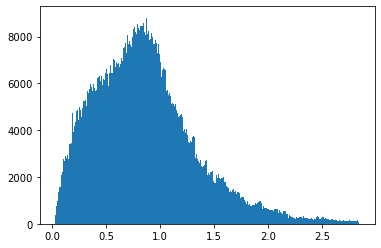

In [10]:
#Calculate dN/dz distributions
z_max = np.max(photz_app)
spacing=1000
delta_z = z_max/spacing
z_grid, dchi_dz_grid = dchi_dz(z_max, spacing)

#for the true n(z), we need to exclude redshifts above the maximum photo-z estimate 
z_spec_cutoff = features[features['specz'] <= z_max]['specz'].to_numpy()

dN_dz_true = dN_dz(z_spec_cutoff, spacing, delta_z)
#dN_dz_phot = dN_dz(z_phot, spacing, delta_z)
#dN_dz_smoothed = gaussian_filter1d(dN_dz_phot, 10)
#z_grid_fit = np.linspace(0, z_max, spacing)

In [11]:
import scipy.integrate as integrate
#sort training sample into bins using specz
#set bin edges based on application set
#bin_edges_training = bin_edges('equal_num', bin_num, photz_app)
#bin_edges_training = [0.0, 0.2602107, 0.3594298, 0.44568676, 0.52895773, 0.60666081, 0.67986793, 0.74469006, 0.80357764, 0.86557952, 0.93931536, 1.04565648, 2.5215    ]
#bin_edges_training = [0., 0.22862562, 0.30561513, 0.33503075, 0.36117446, 0.39428147, 0.46056168, 0.55604625, 0.6206449 , 0.69508432, 0.78285207, 0.90328994, 1.4085    ]
M, M_of_z, M_edges, bin_edges_training = bin_optimizer(z_grid, z_max, dN_dz_true, dchi_dz_grid, 2.25, 2.0, delta_z, bin_num)

#sort validation and training samples into those bins by true redshift
results_training_true = do_binning(specz_training, bin_edges_training, bin_num)
results_val_true = do_binning(specz_val, bin_edges_training, bin_num)
features_training['bins_true'] = results_training_true
features_val['bins_true'] = results_val_true

#sort validation and training samples into those bins by photo-z
results_training_sort = do_binning(photz_training, bin_edges_training, bin_num)
results_val_sort = do_binning(photz_val, bin_edges_training, bin_num)
features_training['bins'] = results_training_sort
features_val['bins'] = results_val_sort

misclassed_training = []
for i in range(len(features_training)):
    if features_training['bins'][i] == features_training['bins_true'][i]:
        misclassed_training.append(1)
    else:
        misclassed_training.append(0)
        
misclassed_validation = []
for j in range(len(features_val)):
    if features_val['bins'][j] == features_val['bins_true'][j]:
        misclassed_validation.append(1)
    else:
        misclassed_validation.append(0)
        
features_training['misclass'] = misclassed_training
features_val['misclass'] = misclassed_validation

In [12]:
#This cell splits the features into multiple dataframes based on bin

training_dict = {}
for i in range(bin_num):
    bin_name = f'bin_{i}'
    if bin_name not in training_dict:
        training_dict[bin_name] = features_training[features_training['bins'] == i]
        
validation_dict = {}
for j in range(bin_num):
    bin_name = f'bin_{j}'
    if bin_name not in validation_dict:
        validation_dict[bin_name] = features_val[features_val['bins'] == j]

In [13]:
for i in range(bin_num):
    nnc_training_features = training_dict[f'bin_{i}'][['specz', 'size', 'g', 'r', 'i', 'z', 'y', 'gr', 'ri', 'iz', 'zy', 'gri', 'riz', 'izy', 'zphot', 'zconf', 'zerr', 'eg', 'er', 'ei', 'ez', 'ey', 'egr', 'eri', 'eiz', 'ezy', 'egri', 'eriz', 'eizy', 'misclass']]
    headers = ['specz', 'size', 'g', 'r', 'i', 'z', 'y', 'gr', 'ri', 'iz', 'zy', 'gri', 'riz', 'izy', 'zphot', 'zconf', 'zerr', 'eg', 'er', 'ei', 'ez', 'ey', 'egr', 'eri', 'eiz', 'ezy', 'egri', 'eriz', 'eizy', 'misclass']
    fmt = ' %.10f' + ' %.5f'*6 + ' %.5e' * 7 + ' %.5e'*12 + ' %.5e'*3 + '%i'
    nnc_training_features.to_csv(f'nn_class/{title_string}/tpzrun.nnc_train_bin_{i}', sep=' ', header=headers, index=False)
    
    nnc_validation_features = validation_dict[f'bin_{i}'][['specz', 'size', 'g', 'r', 'i', 'z', 'y', 'gr', 'ri', 'iz', 'zy', 'gri', 'riz', 'izy', 'zphot', 'zconf', 'zerr', 'eg', 'er', 'ei', 'ez', 'ey', 'egr', 'eri', 'eiz', 'ezy', 'egri', 'eriz', 'eizy', 'misclass']]
    nnc_validation_features.to_csv(f'nn_class/{title_string}/tpzrun.nnc_validate_bin_{i}', sep=' ', header=headers, index=False)  

In [14]:
#now we need to make the application files for each bin

#first, sort application objects into bins based on photo-z
results_app = do_binning(photz_app, bin_edges_training, bin_num)

features['bins'] = results_app

In [15]:
#split application set by bin number
application_dict = {}
for i in range(bin_num):
    bin_name = f'bin_{i}'
    if bin_name not in application_dict:
        application_dict[bin_name] = features[features['bins'] == i]

In [16]:
#save application files

for i in range(bin_num):
    nnc_app_features = application_dict[f'bin_{i}'][['specz', 'size', 'g', 'r', 'i', 'z', 'y', 'gr', 'ri', 'iz', 'zy', 'gri', 'riz', 'izy', 'zphot', 'zconf', 'zerr', 'eg', 'er', 'ei', 'ez', 'ey', 'egr', 'eri', 'eiz', 'ezy', 'egri', 'eriz', 'eizy']]
    headers = ['specz', 'size', 'g', 'r', 'i', 'z', 'y', 'gr', 'ri', 'iz', 'zy', 'gri', 'riz', 'izy', 'zphot', 'zconf', 'zerr', 'eg', 'er', 'ei', 'ez', 'ey', 'egr', 'eri', 'eiz', 'ezy', 'egri', 'eriz', 'eizy']
    fmt = ' %.10f' + ' %.5f'*6 + ' %.5e' * 7 + ' %.5e'*12 + ' %.5e'*3 
    nnc_app_features.to_csv(f'nn_class/{title_string}/tpzrun.nn_app_bin_{i}', sep=' ', header=headers, index=False)
